# Predictive Maintenance for Manufacturing Equipment

*The dataset being analyzed contains sensor readings and operational parameters from an industrial machine, where the goal is to predict failure types. This classification task is crucial for preventive maintenance and ensuring smooth operation in industrial settings. Each row represents a snapshot of the machine's operational state at a given time, while each column contains a specific type of sensor reading or machine attribute.*

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pymongo import MongoClient
from scipy.stats import zscore
from sklearn.preprocessing import StandardScaler
import os
import pickle
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from imblearn.over_sampling import SMOTENC
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, confusion_matrix, classification_report,fbeta_score, make_scorer, silhouette_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from IPython.display import display

In [ ]:
client = MongoClient('mongodb://localhost:27017')
db = client['FinalProject']
collection = db['PredictiveMaintainence']
result = list(collection.find())
data = pd.DataFrame(result)

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure


In [3]:
data.shape

(10000, 10)

In [4]:
data.columns

Index(['UDI', 'Product ID', 'Type', 'Air temperature [K]',
       'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]',
       'Tool wear [min]', 'Target', 'Failure Type'],
      dtype='object')

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Target                   10000 non-null  int64  
 9   Failure Type             10000 non-null  object 
dtypes: float64(3), int64(4), object(3)
memory usage: 781.4+ KB


In [6]:
# data = data.drop('_id', axis=1)

In [7]:
#checking whether product ID is categorical feature or unique identifier
if(data['Product ID'].nunique() == data.shape[0]):
    print("No Duplicates in Product ID")

No Duplicates in Product ID


In [8]:
# No Duplicates in Product ID shows that it is unique identifier
# but it also contains the type of the product
Product_ID_type = data['Product ID'].apply(lambda x: x[0])
Product_ID_type.value_counts()

,count
Product ID,
L,6000
M,2997
H,1003


In [9]:
data['Type'].value_counts()

,count
Type,
L,6000
M,2997
H,1003


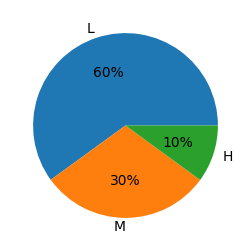

In [10]:
plt.figure(figsize=(3,3))
type_percent = 100 * data['Type'].value_counts() / data.shape[0]
plt.pie(x=type_percent.array, labels=type_percent.index.array,
        colors=sns.color_palette('tab10')[0:4], autopct='%.0f%%')
plt.show()

In [11]:
# The type in product ID is equivalent to Type feature so we can consider Product ID as unique values
# removing unique values
data.drop(['UDI', 'Product ID'], axis=1, inplace=True)

In [12]:
data.describe()

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,300.004930,310.005560,1538.776100,39.986910,107.951000,0.033900
std,2.000259,1.483734,179.284096,9.968934,63.654147,0.180981
min,295.300000,305.700000,1168.000000,3.800000,0.000000,0.000000
25%,298.300000,308.800000,1423.000000,33.200000,53.000000,0.000000
50%,300.100000,310.100000,1503.000000,40.100000,108.000000,0.000000
75%,301.500000,311.100000,1612.000000,46.800000,162.000000,0.000000
max,304.500000,313.800000,2886.000000,76.600000,253.000000,1.000000


In [13]:
data['Tool wear [min]'] = data['Tool wear [min]'].astype('float64')
data['Rotational speed [rpm]'] = data['Rotational speed [rpm]'].astype('float64')

In [14]:
data = data.rename(columns = {'Air temperature [K]': 'Air temperature', 'Process temperature [K]': 'Process temperature',
       'Rotational speed [rpm]': 'Rotational speed', 'Torque [Nm]': 'Torque', 'Tool wear [min]': 'Tool wear'})

In [15]:
sensor_readings = ['Air temperature', 'Process temperature', 'Rotational speed', 'Torque', 'Tool wear']

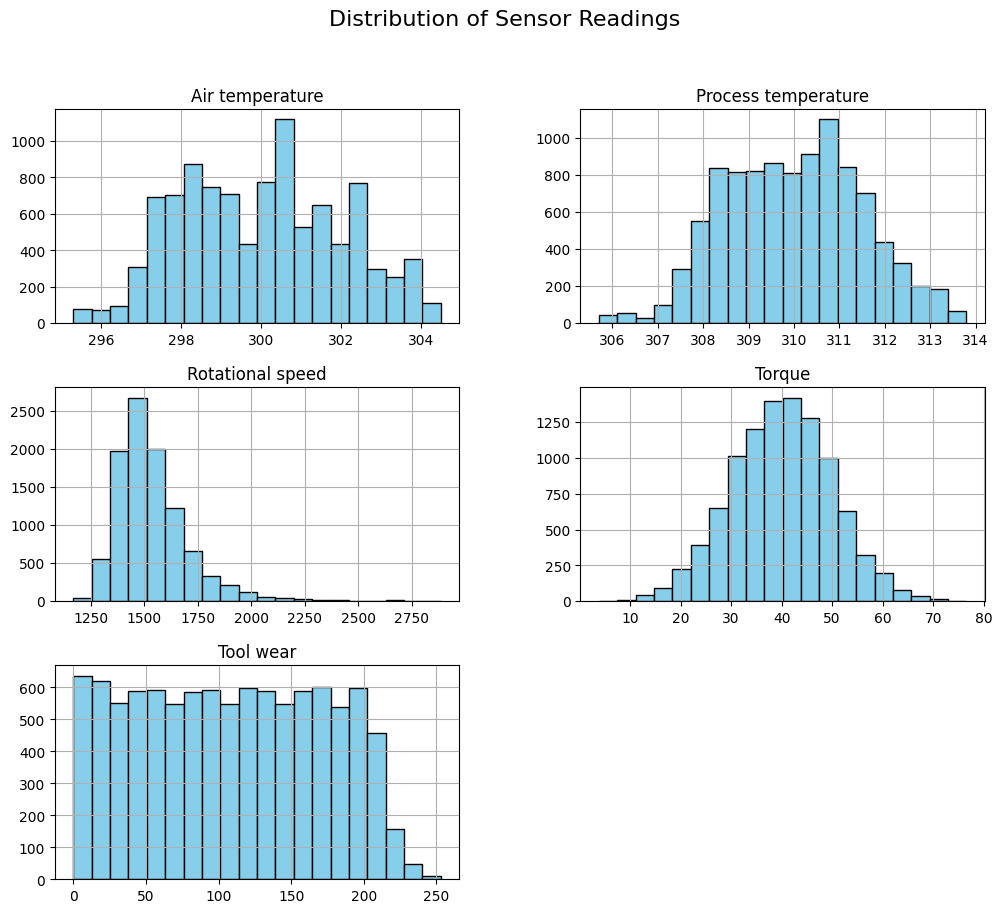

In [16]:
data[sensor_readings].hist(figsize=(12,10), bins=20, color='skyblue', edgecolor = 'black')
plt.suptitle('Distribution of Sensor Readings', fontsize=16)
plt.show()

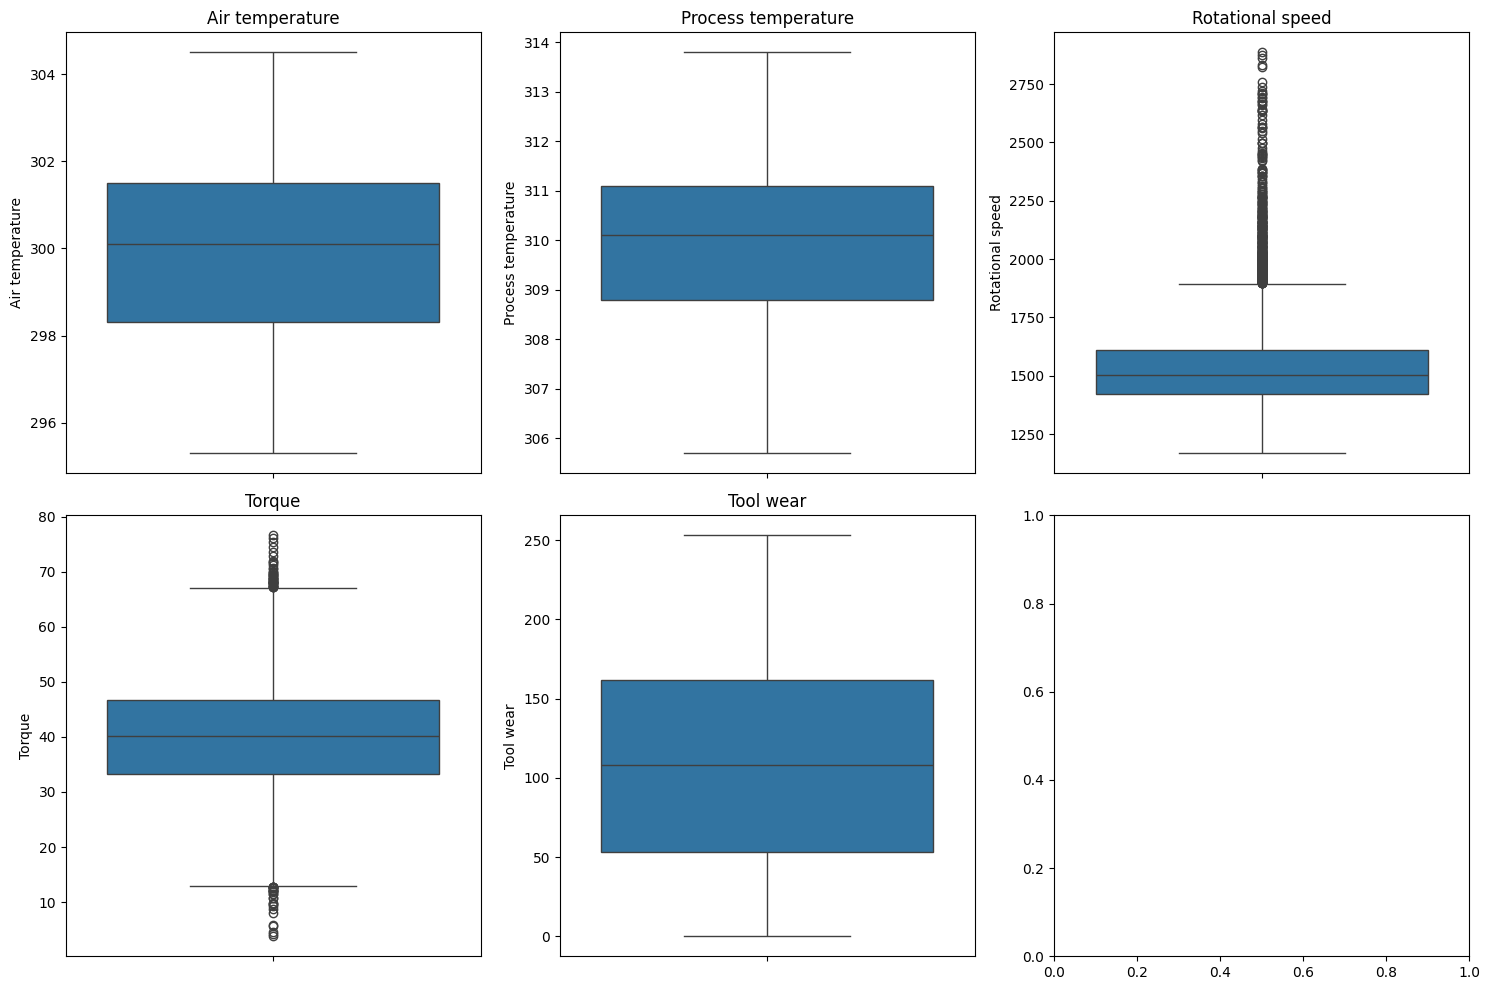

In [17]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15,10))
for i, col in enumerate(data[sensor_readings]):
    row, column = i//3, i%3
    sns.boxplot(data = data[col], ax = axes[row,column])
    axes[row, column].set_title(col)

plt.tight_layout()
plt.show()

In [18]:
df = data.copy()

Target and Failure Type Distribution

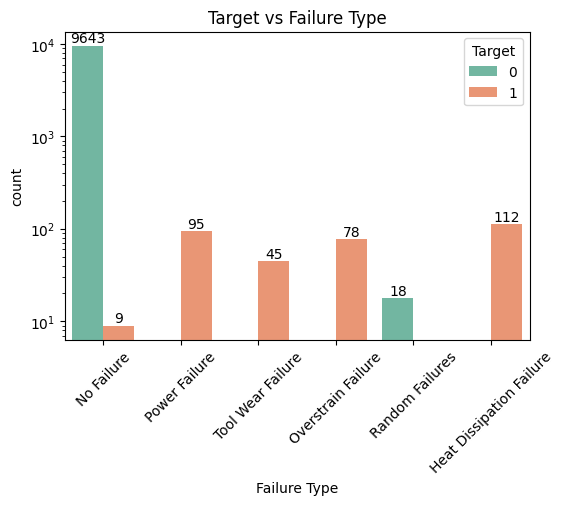

In [19]:
plt.figure(figsize=(6,4))
sns.countplot(x='Failure Type', data = df, hue = 'Target', width=0.8, palette = 'Set2', legend = True)
for p in plt.gca().patches:
    plt.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2, p.get_height()), ha = 'center', va = 'bottom')
plt.yscale('log')
plt.title('Target vs Failure Type')
plt.xticks(rotation=45)
plt.show()

*The* above plot shows **9 No Failure type** having Target as 1 and **Random Failures Type** having all Target values as 0

In [20]:
df = df[~((df['Failure Type']=='No Failure') & (df['Target']==1))]
df = df[~(((df['Failure Type']=='Random Failures') & (df['Target']==0)))]

Handling imbalanced data

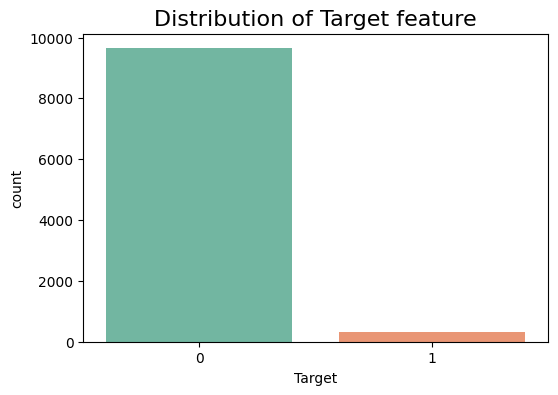

In [21]:
plt.figure(figsize=(6,4))
sns.countplot(x='Target', data=df, hue='Target', palette='Set2', legend=False)
plt.title('Distribution of Target feature', fontsize=16)
plt.show()

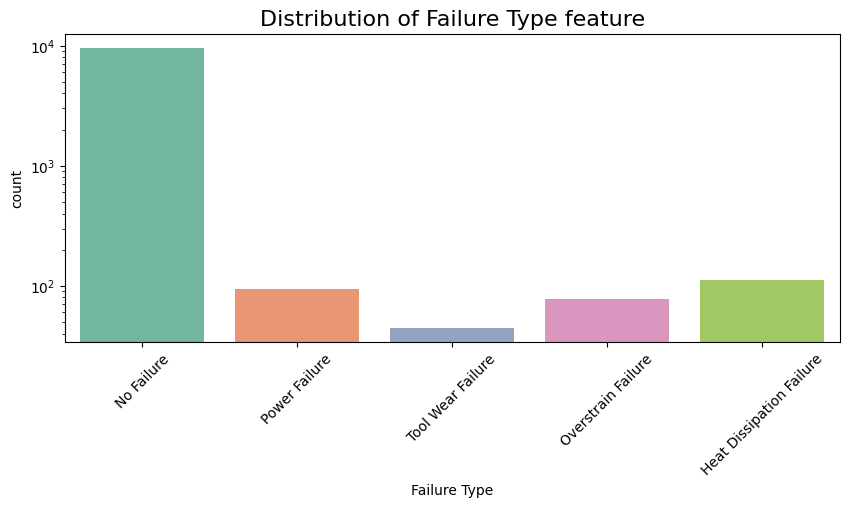

In [22]:
plt.figure(figsize=(10,4))
sns.countplot(x='Failure Type', data=df, hue='Failure Type', palette='Set2', legend=False)
plt.yscale('log')
plt.title('Distribution of Failure Type feature', fontsize=16)
plt.xticks(rotation=45)
plt.show()

In [23]:
no_failure = int((df['Failure Type'] == 'No Failure').sum())
minority_class = df['Failure Type'].nunique() - 1
minority_percent = 0.20
final_count = no_failure / (1 - minority_percent)
sample_per_class = round((final_count - no_failure) / minority_class)
balance_cause = {'No Failure':no_failure,
                 'Overstrain Failure':sample_per_class,
                 'Heat Dissipation Failure':sample_per_class,
                 'Power Failure':sample_per_class,
                 'Tool Wear Failure':sample_per_class}

In [24]:
sm = SMOTENC(categorical_features=[0,7], sampling_strategy=balance_cause, random_state=0)
df_res, y_res = sm.fit_resample(df, df['Failure Type'])

Scaling

In [25]:
df2 = df_res.copy()

In [26]:
sc = StandardScaler()
df2[sensor_readings] = sc.fit_transform(df2[sensor_readings])

In [27]:
df2['Type'] = df2['Type'].map({'L': 0, 'M': 1, 'H': 2})
df2['Failure Type'] = df2['Failure Type'].map({'No Failure': 0, 'Power Failure': 1, 'Tool Wear Failure': 2,
                                                 'Overstrain Failure': 3, 'Heat Dissipation Failure': 4})

In [ ]:
data_to_be_inserted = df2.to_dict('records')
res = db['CleanedData'].insert_many(data_to_be_inserted)

In [ ]:
result_data = list(db['CleanedData'].find())
final_df = pd.DataFrame(result_data)
final_df = final_df.drop('_id', axis=1)

In [ ]:
X = final_df.drop(['Target', 'Failure Type'], axis=1)
y = final_df[['Target','Failure Type']]

In [29]:
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.1, stratify=df2['Failure Type'], random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.11, stratify=y_trainval['Failure Type'], random_state=0)

In [30]:
print(f'Train set percentage: {X_train.shape[0] * 100 /df_res.shape[0] : .2f}%')
print(f'Validation set percentage: {X_val.shape[0] * 100 /df_res.shape[0] : .2f}%')
print(f'Test set percentage: {X_test.shape[0] * 100 /df_res.shape[0] : .2f}%')

Train set percentage:  80.09%
Validation set percentage:  9.90%
Test set percentage:  10.00%


### Supervised Learning - Binary Classification

In [31]:
models = {
    'Random Forest': {
        'model': RandomForestClassifier(random_state=42),
        'param_grid': {
            'n_estimators':[100,300,500,700],
            'max_depth':[5,7,10],
            'random_state':[0]
        }
    },
    'XGBoost': {
        'model': XGBClassifier(random_state=42),
        'param_grid': {
            'n_estimators':[300,500,700],
            'max_depth':[5,7],
            'learning_rate':[0.01,0.1],
            'objective':['binary:logistic']
        }
    },
    'Neural Network': {
        'model': MLPClassifier(max_iter=1000, random_state=42),
        'param_grid': {
            'hidden_layer_sizes': [(10,), (20,)],
            'activation': ['relu'],
            'solver': ['adam'],
            'alpha': [0.0001],
            'learning_rate': ['constant']
        }
    }
}

In [32]:
def evaluate_binary_models(model, X_test, y_test):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test['Target'], y_pred)
    y_pred_prob = model.predict_proba(X_test)[:,1]
    acc = round(accuracy_score(y_test['Target'], y_pred), 3)
    auc = round(roc_auc_score(y_test['Target'], y_pred_prob), 3)
    f1 = round(f1_score(y_test['Target'], y_pred, pos_label=1), 3)

    metrics = {
        'model': model.__class__.__name__,
        'accuracy': acc,
        'roc score': auc,
        'f1 score': f1,
    }
    return metrics, cm

In [33]:
def conf_matrix(cm_list, title, class_labels):
    fig, axes = plt.subplots(nrows=1, ncols=len(cm_list), figsize=(18, 5))

    fig.suptitle(f'Confusion Matrices for {title}', fontsize=16)

    for i, (name, cm) in enumerate(cm_list.items()):
        sns.heatmap(cm, annot=True, fmt='g', cmap='Blues',
                    xticklabels=class_labels, yticklabels=class_labels, ax=axes[i])
        axes[i].set_title(name)
        axes[i].set_xlabel('Predicted Label')
        axes[i].set_ylabel('True Label')

    plt.tight_layout()
    plt.show()

In [34]:
fitted_models = {}
for name, details in models.items():
    model = details['model']
    params = details['param_grid']

    print(f'Fitting and Tuning {name}...')

    f2_scorer = make_scorer(fbeta_score, pos_label=1, beta=2)
    grid_search = GridSearchCV(model, param_grid=params, cv=5, scoring=f2_scorer)
    grid_search.fit(X_train, y_train['Target'])
    best_params = grid_search.best_params_

    fitted_models[name] = {
        'model': grid_search.best_estimator_,
        'best_params': best_params
    }
    print(best_params)

Fitting and Tuning Random Forest...


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


{'max_depth': 10, 'n_estimators': 700, 'random_state': 0}
Fitting and Tuning XGBoost...
{'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 700, 'objective': 'binary:logistic'}
Fitting and Tuning Neural Network...
{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (20,), 'learning_rate': 'constant', 'solver': 'adam'}


In [35]:
val_metrics_list = []
val_cm_list = {}
test_metrics_list = []
test_cm_list = {}

for name, details in fitted_models.items():
    val_metrics, val_cm = evaluate_binary_models(details['model'], X_val, y_val)

    val_cm_list[name] = val_cm

    val_metrics_list.append({
        'Model' : name,
        'Accuracy' : val_metrics['accuracy'],
        'ROC Score' : val_metrics['roc score'],
        'F1 score': val_metrics['f1 score']
       })

    val_metrics_df = pd.DataFrame(val_metrics_list)

    test_metrics, test_cm = evaluate_binary_models(details['model'], X_test, y_test)

    test_cm_list[name] = test_cm

    test_metrics_list.append({
        'Model' : name,
        'Accuracy' : test_metrics['accuracy'],
        'ROC Score' : test_metrics['roc score'],
        'F1 score': test_metrics['f1 score']
       })
    test_metrics_df = pd.DataFrame(test_metrics_list)

In [36]:
print('Evaluation Metrics of Validation Dataset')
display(val_metrics_df)
print('Evaluation Metrics of Test Dataset')
display(test_metrics_df)

Evaluation Metrics of Validation Dataset


,Model,Accuracy,ROC Score,F1 score
0,Random Forest,0.974,0.997,0.937
1,XGBoost,0.987,0.999,0.967
2,Neural Network,0.947,0.988,0.868


Evaluation Metrics of Test Dataset


,Model,Accuracy,ROC Score,F1 score
0,Random Forest,0.975,0.998,0.939
1,XGBoost,0.984,0.999,0.961
2,Neural Network,0.939,0.987,0.849


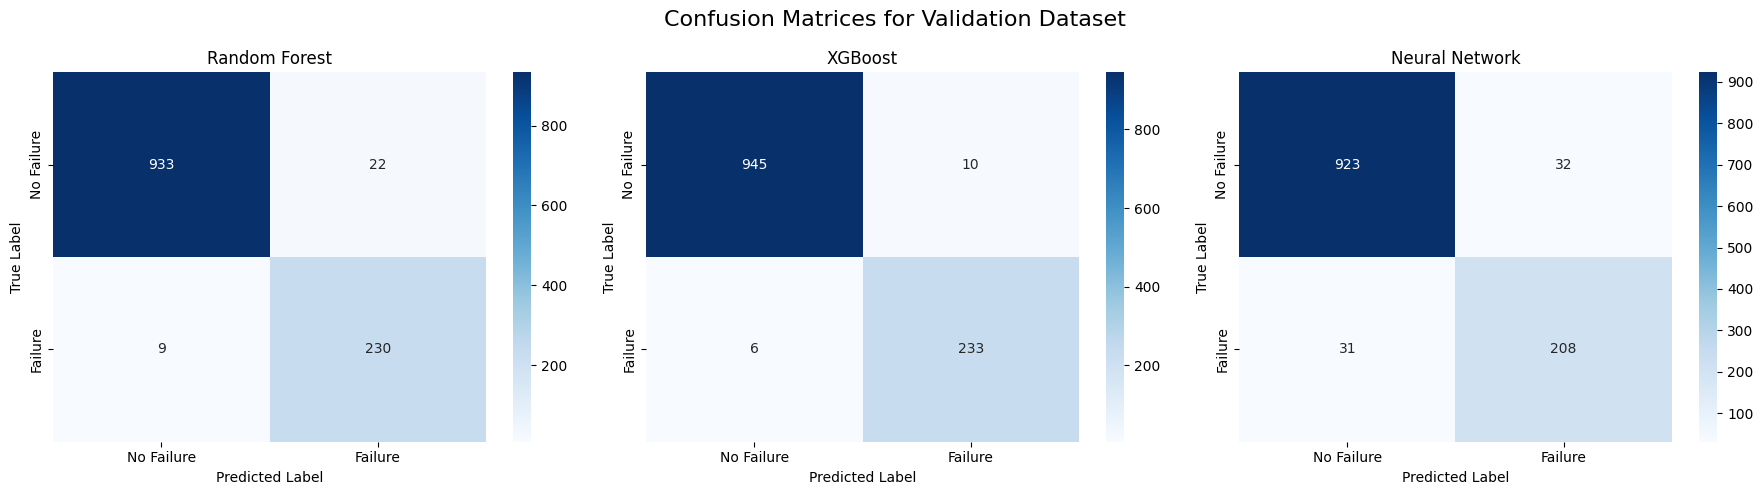

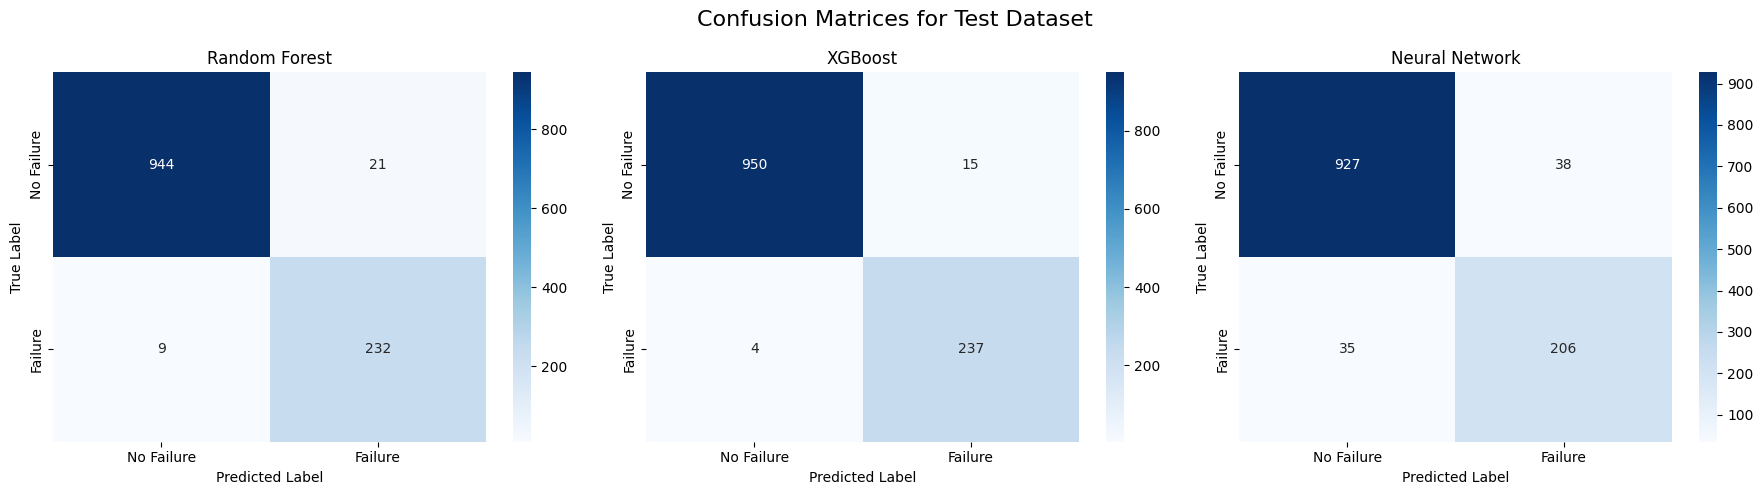

In [37]:
class_labels = ['No Failure', 'Failure']
conf_matrix(val_cm_list, 'Validation Dataset', class_labels)
conf_matrix(test_cm_list, 'Test Dataset', class_labels)

### Supervised Learning - Multi Class Classification

In [38]:
fitted_models_multi = {}
for name, details in models.items():
    model = details['model']
    params = details['param_grid']

    print(f'Fitting and Tuning {name}...')

    f2_scorer = make_scorer(fbeta_score, beta=2, average='weighted')
    grid_search = GridSearchCV(model, param_grid=params, cv=5, scoring=f2_scorer)
    grid_search.fit(X_train, y_train['Failure Type'])
    best_params = grid_search.best_params_

    fitted_models_multi[name] = {
        'model': grid_search.best_estimator_,
        'best_params': best_params
    }
    print(best_params)

Fitting and Tuning Random Forest...
{'max_depth': 10, 'n_estimators': 500, 'random_state': 0}
Fitting and Tuning XGBoost...
{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 500, 'objective': 'binary:logistic'}
Fitting and Tuning Neural Network...
{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (20,), 'learning_rate': 'constant', 'solver': 'adam'}


In [39]:
def evaluate_multiclass_models(model, X_test, y_test):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test['Failure Type'], y_pred)
    y_pred_prob = model.predict_proba(X_test)
    acc = round(accuracy_score(y_test['Failure Type'], y_pred), 3)
    auc = round(roc_auc_score(y_test['Failure Type'], y_pred_prob,multi_class='ovr', average='weighted'), 3)
    f1 = round(f1_score(y_test['Failure Type'], y_pred, average='weighted'), 3)

    metrics = {
        'model': model.__class__.__name__,
        'accuracy': acc,
        'roc score': auc,
        'f1 score': f1,
    }
    return metrics, cm

In [40]:
val_metrics_list_multi = []
val_cm_list_multi = {}
test_metrics_list_multi = []
test_cm_list_multi = {}

for name, details in fitted_models_multi.items():
    val_metrics_multi, val_cm_multi = evaluate_multiclass_models(details['model'], X_val, y_val)

    val_cm_list_multi[name] = val_cm_multi

    val_metrics_list_multi.append({
        'Model' : name,
        'Accuracy' : val_metrics_multi['accuracy'],
        'ROC Score' : val_metrics_multi['roc score'],
        'F1 score': val_metrics_multi['f1 score']
       })

    val_metrics_df_multi = pd.DataFrame(val_metrics_list_multi)

    test_metrics_multi, test_cm_multi = evaluate_multiclass_models(details['model'], X_test, y_test)

    test_cm_list_multi[name] = test_cm_multi

    test_metrics_list_multi.append({
        'Model' : name,
        'Accuracy' : test_metrics_multi['accuracy'],
        'ROC Score' : test_metrics_multi['roc score'],
        'F1 score': test_metrics_multi['f1 score']
       })
    test_metrics_df_multi = pd.DataFrame(test_metrics_list_multi)

In [41]:
print('Evaluation Metrics of Validation Dataset')
display(val_metrics_df_multi)
print('Evaluation Metrics of Test Dataset')
display(test_metrics_df_multi)

Evaluation Metrics of Validation Dataset


,Model,Accuracy,ROC Score,F1 score
0,Random Forest,0.977,0.998,0.977
1,XGBoost,0.984,0.999,0.984
2,Neural Network,0.956,0.994,0.954


Evaluation Metrics of Test Dataset


,Model,Accuracy,ROC Score,F1 score
0,Random Forest,0.974,0.998,0.975
1,XGBoost,0.984,0.999,0.984
2,Neural Network,0.959,0.994,0.959


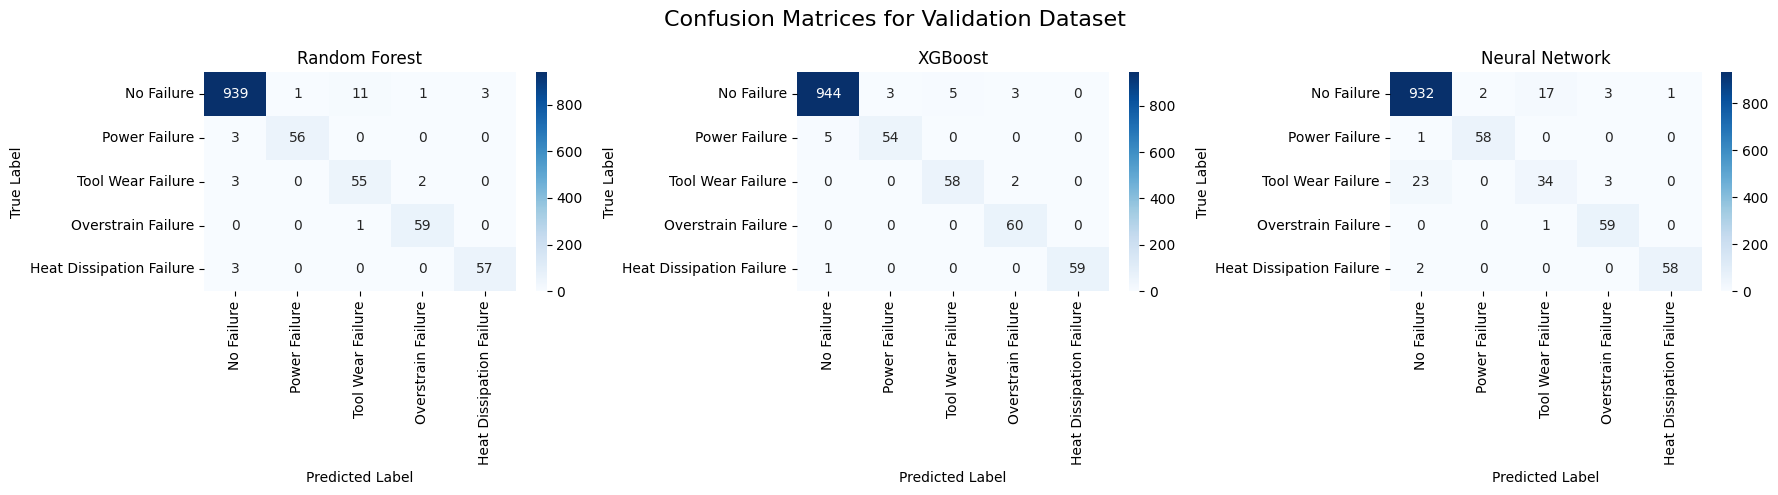

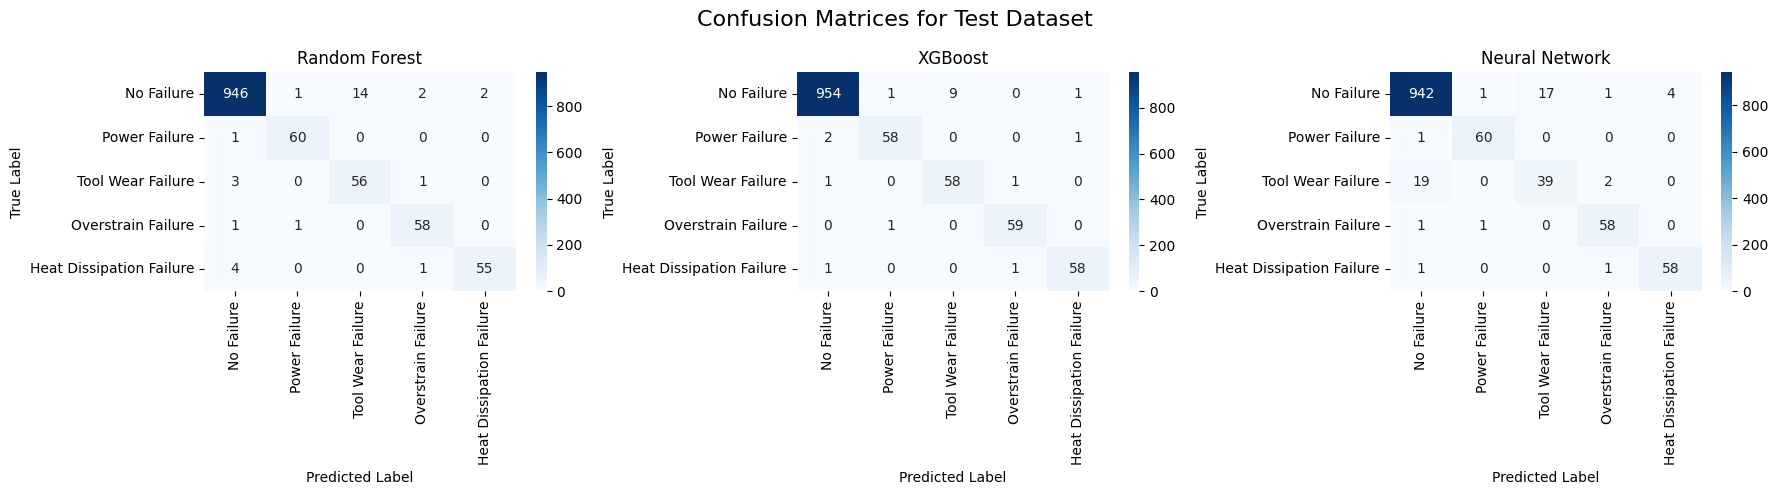

In [42]:
class_labels = ['No Failure', 'Power Failure', 'Tool Wear Failure', 'Overstrain Failure', 'Heat Dissipation Failure']
conf_matrix(val_cm_list_multi, 'Validation Dataset', class_labels)
conf_matrix(test_cm_list_multi, 'Test Dataset', class_labels)

In [47]:
binary_model = fitted_models['XGBoost']['model']
binary_model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=700, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [48]:
with open(os.path.join('pickle', 'binary_xgb.pkl'),'wb') as f:
    pickle.dump(binary_model, f)

In [49]:
multi_model = fitted_models_multi['XGBoost']['model']
multi_model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [50]:
with open(os.path.join('pickle', 'multi_xgb.pkl'),'wb') as f:
    pickle.dump(multi_model, f)